In [2]:
# ============================================================================
# 셀 1: 라이브러리 임포트
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, precision_recall_curve, auc)
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Optional SHAP (skip if not available or incompatible)
try:
    import shap  # type: ignore
    _has_shap = True
except Exception:
    _has_shap = False
 
# Optional gradient boosting libraries
try:
    from xgboost import XGBClassifier  # type: ignore
    _has_xgb = True
except Exception:
    _has_xgb = False
 
try:
    from lightgbm import LGBMClassifier  # type: ignore
    _has_lgbm = True
except Exception:
    _has_lgbm = False

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 노트북에서 실행 시 인라인 백엔드 활성화 (오타 매직 없이 안전하게)
try:
    from IPython import get_ipython  # type: ignore
    _ip = get_ipython()
    if _ip is not None:
        _ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


In [3]:
# ============================================================================
# 커스텀 라벨 인코더 클래스
# ============================================================================

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    """파이프라인에서 사용할 수 있는 라벨 인코더"""
    
    def __init__(self):
        self.label_encoders = {}
        self.is_fitted = False
    
    def fit(self, X, y=None):
        self.label_encoders = {}
        # X가 DataFrame인지 numpy array인지 확인
        if hasattr(X, 'iloc'):
            # DataFrame인 경우
            for i in range(X.shape[1]):
                le = LabelEncoder()
                le.fit(X.iloc[:, i].astype(str))
                self.label_encoders[i] = le
        else:
            # numpy array인 경우
            for i in range(X.shape[1]):
                le = LabelEncoder()
                le.fit(X[:, i].astype(str))
                self.label_encoders[i] = le
        self.is_fitted = True
        return self
    
    def transform(self, X):
        if not self.is_fitted:
            raise ValueError("Must fit before transform")
        
        if hasattr(X, 'iloc'):
            # DataFrame인 경우
            X_encoded = X.copy()
            for i in range(X.shape[1]):
                try:
                    X_encoded.iloc[:, i] = self.label_encoders[i].transform(X.iloc[:, i].astype(str))
                except ValueError:
                    # 새로운 라벨이 있는 경우 -1로 처리
                    unique_labels = set(X.iloc[:, i].astype(str))
                    known_labels = set(self.label_encoders[i].classes_)
                    new_labels = unique_labels - known_labels
                    if new_labels:
                        print(f"⚠️ 새로운 라벨 발견: {new_labels}, -1로 처리합니다.")
                    X_encoded.iloc[:, i] = X.iloc[:, i].astype(str).apply(
                        lambda x: self.label_encoders[i].transform([x])[0] if x in self.label_encoders[i].classes_ else -1
                    )
            return X_encoded.astype(float)
        else:
            # numpy array인 경우
            X_encoded = X.copy()
            for i in range(X.shape[1]):
                try:
                    X_encoded[:, i] = self.label_encoders[i].transform(X[:, i].astype(str))
                except ValueError:
                    # 새로운 라벨이 있는 경우 -1로 처리
                    unique_labels = set(X[:, i].astype(str))
                    known_labels = set(self.label_encoders[i].classes_)
                    new_labels = unique_labels - known_labels
                    if new_labels:
                        print(f"⚠️ 새로운 라벨 발견: {new_labels}, -1로 처리합니다.")
                    X_encoded[:, i] = np.array([
                        self.label_encoders[i].transform([x])[0] if x in self.label_encoders[i].classes_ else -1
                        for x in X[:, i].astype(str)
                    ])
            return X_encoded.astype(float)


In [4]:
# ============================================================================
# 셀 2: 데이터 로딩 및 전처리
# ============================================================================

# 데이터 로드 (Football: curated CSVs)
DATA_DIR = Path.cwd().parent / "data" / "curated"
csv_files = {p.name: p for p in sorted(DATA_DIR.glob("*.csv"))}
print("📁 발견된 CSV:")
for i, name in enumerate(csv_files.keys(), 1):
    print(f"  {i}. {name}")

# 단일 CSV 사용 시나리오 지원: TARGET_CSV_NAME 지정 또는 자동 선택
TARGET_CSV_NAME = globals().get('TARGET_CSV_NAME', None)
if TARGET_CSV_NAME and TARGET_CSV_NAME in csv_files:
    dataset_path = csv_files[TARGET_CSV_NAME]
else:
    # transfer 컬럼 포함 파일 우선 선택
    chosen = None
    for name, path in csv_files.items():
        try:
            head = pd.read_csv(path, nrows=50, low_memory=True)
            if 'transfer' in head.columns:
                chosen = name
                break
        except Exception:
            continue
    if chosen is None:
        # 첫 번째 CSV 사용
        if not csv_files:
            raise FileNotFoundError("curated 디렉토리에 CSV 파일이 없습니다.")
        chosen = next(iter(csv_files.keys()))
    TARGET_CSV_NAME = chosen
    dataset_path = csv_files[chosen]

df_dataset = pd.read_csv(dataset_path, low_memory=True)
print(f"✅ {TARGET_CSV_NAME} 로드 완료: {df_dataset.shape}")

# 모델 데이터프레임 구성 (단일 CSV 기반)
df_model = df_dataset.copy()

# 시즌 컬럼 탐색 및 시즌 시작연도 계산
def _detect_season_column(df: pd.DataFrame):
    candidate_cols = [c for c in df.columns if 'season' in c.lower()]
    for c in candidate_cols:
        try:
            if df[c].astype(str).str.contains(r"^\d{2}/\d{2}$", na=False).any():
                return c
        except Exception:
            continue
    for c in df.columns:
        try:
            if df[c].astype(str).str.contains(r"^\d{2}/\d{2}$", na=False).any():
                return c
        except Exception:
            continue
    return None

season_col = _detect_season_column(df_model)

def _season_start_year(s: str) -> float:
    try:
        s = str(s)
        if '/' in s:
            yy = int(s.split('/')[0])
            return 2000 + yy
    except Exception:
        return np.nan
    return np.nan

if season_col is not None:
    df_model['season_start_year'] = df_model[season_col].apply(_season_start_year)

# age_at_season: 시즌 시작연도 - 출생연도(앞 4자리)
if 'date_of_birth' in df_model.columns and 'season_start_year' in df_model.columns:
    by = df_model['date_of_birth'].astype(str).str.extract(r"^(\d{4})")[0]
    birth_year = pd.to_numeric(by, errors='coerce')
    df_model['age_at_season'] = (df_model['season_start_year'] - birth_year).astype('float')

# 로그 시장가치, 가치 성장, 협상 프록시
if 'market_value_in_eur' in df_model.columns:
    df_model['log_market_value'] = np.log1p(pd.to_numeric(df_model['market_value_in_eur'], errors='coerce'))
if 'highest_market_value_in_eur' in df_model.columns and 'market_value_in_eur' in df_model.columns:
    mv = pd.to_numeric(df_model['market_value_in_eur'], errors='coerce')
    mv_hi = pd.to_numeric(df_model['highest_market_value_in_eur'], errors='coerce')
    df_model['value_growth'] = (mv_hi - mv)
    df_model['negotiation_proxy'] = 0.6 * mv + 0.4 * mv_hi

# agent_name 드랍
if 'agent_name' in df_model.columns:
    df_model = df_model.drop(columns=['agent_name'])

# 23/24, 24/25 시즌 제외 (미래 데이터)
if season_col is not None:
    before = len(df_model)
    df_model = df_model[~df_model[season_col].astype(str).isin(['23/24', '24/25'])].copy()
    after = len(df_model)
    if before != after:
        print(f"🧹 미래 시즌 제외 (23/24, 24/25): {before-after:,}건 제거")
        print(f"   - 23/24: {before - len(df_model[df_model[season_col].astype(str) == '23/24']):,}건")
        print(f"   - 24/25: {before - len(df_model[df_model[season_col].astype(str) == '24/25']):,}건")

# 타겟 설정: transfer 컬럼이 존재해야 함 (없으면 오류)
if 'transfer' not in df_model.columns:
    raise ValueError("선택된 CSV에 'transfer' 타겟 컬럼이 없습니다. TARGET_CSV_NAME을 확인하세요.")

TARGET_COL = 'transfer'
df_model[TARGET_COL] = pd.to_numeric(df_model[TARGET_COL], errors='coerce').fillna(0).astype(int)
print(f"✅ 타겟 설정: {TARGET_COL}")
print(f"✅ 타겟 요약: 샘플 {len(df_model):,}개, 양성 비율 {df_model[TARGET_COL].mean()*100:.1f}%")

print("✅ 데이터 전처리 설정 완료 (Football 데이터)")

📁 발견된 CSV:
  1. player_final.csv
✅ player_final.csv 로드 완료: (6910, 24)
🧹 미래 시즌 제외 (23/24, 24/25): 1,083건 제거
   - 23/24: 6,910건
   - 24/25: 6,910건
✅ 타겟 설정: transfer
✅ 타겟 요약: 샘플 5,827개, 양성 비율 14.4%
✅ 데이터 전처리 설정 완료 (Football 데이터)


In [5]:
# ============================================================================
# 셀 2: 데이터 로딩 및 전처리
# ============================================================================

# 데이터 로드 (Football: curated CSVs)
DATA_DIR = Path.cwd().parent / "data" / "curated"
csv_files = {p.name: p for p in sorted(DATA_DIR.glob("*.csv"))}
print("📁 발견된 CSV:")
for i, name in enumerate(csv_files.keys(), 1):
    print(f"  {i}. {name}")

# 단일 CSV 사용 시나리오 지원: TARGET_CSV_NAME 지정 또는 자동 선택
TARGET_CSV_NAME = globals().get('TARGET_CSV_NAME', None)
if TARGET_CSV_NAME and TARGET_CSV_NAME in csv_files:
    dataset_path = csv_files[TARGET_CSV_NAME]
else:
    # transfer 컬럼 포함 파일 우선 선택
    chosen = None
    for name, path in csv_files.items():
        try:
            head = pd.read_csv(path, nrows=50, low_memory=True)
            if 'transfer' in head.columns:
                chosen = name
                break
        except Exception:
            continue
    if chosen is None:
        # 첫 번째 CSV 사용
        if not csv_files:
            raise FileNotFoundError("curated 디렉토리에 CSV 파일이 없습니다.")
        chosen = next(iter(csv_files.keys()))
    TARGET_CSV_NAME = chosen
    dataset_path = csv_files[chosen]

df_dataset = pd.read_csv(dataset_path, low_memory=True)
print(f"✅ {TARGET_CSV_NAME} 로드 완료: {df_dataset.shape}")

# 모델 데이터프레임 구성 (단일 CSV 기반)
df_model = df_dataset.copy()

# 시즌 컬럼 탐색 및 시즌 시작연도 계산
def _detect_season_column(df: pd.DataFrame):
    candidate_cols = [c for c in df.columns if 'season' in c.lower()]
    for c in candidate_cols:
        try:
            if df[c].astype(str).str.contains(r"^\d{2}/\d{2}$", na=False).any():
                return c
        except Exception:
            continue
    for c in df.columns:
        try:
            if df[c].astype(str).str.contains(r"^\d{2}/\d{2}$", na=False).any():
                return c
        except Exception:
            continue
    return None

season_col = _detect_season_column(df_model)

def _season_start_year(s: str) -> float:
    try:
        s = str(s)
        if '/' in s:
            yy = int(s.split('/')[0])
            return 2000 + yy
    except Exception:
        return np.nan
    return np.nan

if season_col is not None:
    df_model['season_start_year'] = df_model[season_col].apply(_season_start_year)

# age_at_season: 시즌 시작연도 - 출생연도(앞 4자리)
if 'date_of_birth' in df_model.columns and 'season_start_year' in df_model.columns:
    by = df_model['date_of_birth'].astype(str).str.extract(r"^(\d{4})")[0]
    birth_year = pd.to_numeric(by, errors='coerce')
    df_model['age_at_season'] = (df_model['season_start_year'] - birth_year).astype('float')

# 로그 시장가치, 가치 성장, 협상 프록시
if 'market_value_in_eur' in df_model.columns:
    df_model['log_market_value'] = np.log1p(pd.to_numeric(df_model['market_value_in_eur'], errors='coerce'))
if 'highest_market_value_in_eur' in df_model.columns and 'market_value_in_eur' in df_model.columns:
    mv = pd.to_numeric(df_model['market_value_in_eur'], errors='coerce')
    mv_hi = pd.to_numeric(df_model['highest_market_value_in_eur'], errors='coerce')
    df_model['value_growth'] = (mv_hi - mv)
    df_model['negotiation_proxy'] = 0.6 * mv + 0.4 * mv_hi

# agent_name 드랍
if 'agent_name' in df_model.columns:
    df_model = df_model.drop(columns=['agent_name'])

# 23/24, 24/25 시즌 제외 (미래 데이터)
if season_col is not None:
    before = len(df_model)
    df_model = df_model[~df_model[season_col].astype(str).isin(['23/24', '24/25'])].copy()
    after = len(df_model)
    if before != after:
        print(f"🧹 미래 시즌 제외 (23/24, 24/25): {before-after:,}건 제거")
        print(f"   - 23/24: {before - len(df_model[df_model[season_col].astype(str) == '23/24']):,}건")
        print(f"   - 24/25: {before - len(df_model[df_model[season_col].astype(str) == '24/25']):,}건")

# 타겟 설정: transfer 컬럼이 존재해야 함 (없으면 오류)
if 'transfer' not in df_model.columns:
    raise ValueError("선택된 CSV에 'transfer' 타겟 컬럼이 없습니다. TARGET_CSV_NAME을 확인하세요.")

TARGET_COL = 'transfer'
df_model[TARGET_COL] = pd.to_numeric(df_model[TARGET_COL], errors='coerce').fillna(0).astype(int)
print(f"✅ 타겟 설정: {TARGET_COL}")
print(f"✅ 타겟 요약: 샘플 {len(df_model):,}개, 양성 비율 {df_model[TARGET_COL].mean()*100:.1f}%")

print("✅ 데이터 전처리 설정 완료 (Football 데이터)")


📁 발견된 CSV:
  1. player_final.csv
✅ player_final.csv 로드 완료: (6910, 24)
🧹 미래 시즌 제외 (23/24, 24/25): 1,083건 제거
   - 23/24: 6,910건
   - 24/25: 6,910건
✅ 타겟 설정: transfer
✅ 타겟 요약: 샘플 5,827개, 양성 비율 14.4%
✅ 데이터 전처리 설정 완료 (Football 데이터)


In [6]:
# ============================================================================
# 셀 3: 피쳐 선택 및 데이터 준비
# ============================================================================

target_col = TARGET_COL

# 하이브리드 인코딩을 위한 피쳐 분류
# 순서가 있는 변수들 (라벨 인코딩)
ordinal_features = [
    'season',  # 시간 순서
    'position',  # 포지션별 중요도 순서
    'sub_position'  # 세부 포지션별 중요도 순서
]

# 순서가 없는 변수들 (원핫 인코딩)
nominal_features = [
    'club_name',  # 클럽별 특성 (순서 없음)
    'country_of_birth',  # 국가별 특성 (순서 없음)
    'foot'  # 발 선호도 (순서 없음)
]

# 수치형 변수들 (실제로 수치형인 것만)
numeric_features = [
    c for c in df_model.columns 
    if c not in ordinal_features + nominal_features + [target_col]
    and pd.api.types.is_numeric_dtype(df_model[c])
    and df_model[c].dtype in ['int64', 'float64', 'int32', 'float32']
]

# 존재하는 피쳐만 선택
ordinal_features = [c for c in ordinal_features if c in df_model.columns]
nominal_features = [c for c in nominal_features if c in df_model.columns]

modeling_features = numeric_features + ordinal_features + nominal_features

print(f"📊 하이브리드 인코딩 피쳐 분류:")
print(f"  - 수치형: {len(numeric_features)}개 - {numeric_features}")
print(f"  - 순서형 (라벨 인코딩): {len(ordinal_features)}개 - {ordinal_features}")
print(f"  - 명목형 (원핫 인코딩): {len(nominal_features)}개 - {nominal_features}")

"""
IMPORTANT: 결측치 처리 순서 변경 (데이터 누수 방지)
- 기존: 전체 데이터에서 결측치 대체 후 train/test split
- 변경: split 이후, 훈련 데이터로 imputer 학습 → train/test에 적용
"""

# 데이터 준비 (결측치 채우지 않음, 파이프라인에서 처리)
X = df_model[modeling_features]
Y = df_model[target_col]

print(f"📊 모델링 데이터 크기: {X.shape}")
print(f"🎯 타겟 변수 분포:")
print(Y.value_counts(normalize=True))

📊 하이브리드 인코딩 피쳐 분류:
  - 수치형: 15개 - ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'season_start_year', 'age_at_season']
  - 순서형 (라벨 인코딩): 3개 - ['season', 'position', 'sub_position']
  - 명목형 (원핫 인코딩): 3개 - ['club_name', 'country_of_birth', 'foot']
📊 모델링 데이터 크기: (5827, 21)
🎯 타겟 변수 분포:
transfer
0    0.856358
1    0.143642
Name: proportion, dtype: float64


In [7]:
# =========================================================================
# 셀 4: 데이터 분할 (12/13~22/23 시즌으로 train/test 분할)
# =========================================================================

print("📅 사용 가능한 시즌 범위: 12/13 ~ 22/23 (23/24, 24/25 제외)")
print("🎯 실제 시나리오: 22년까지의 데이터로 23/24 시즌 예측")

# 시즌별 분포 확인
if season_col is not None:
    season_dist = df_model[season_col].value_counts().sort_index()
    print(f"\n📊 사용된 시즌별 데이터 분포:")
    for season, count in season_dist.items():
        print(f"   {season}: {count:,}건")

# 22/23 시즌을 테스트로 사용 (가장 최근 시즌)
if season_col is not None and '22/23' in df_model[season_col].astype(str).values:
    test_mask = df_model[season_col].astype(str) == '22/23'
    X_train, X_test = X[~test_mask], X[test_mask]
    y_train, y_test = Y[~test_mask], Y[test_mask]
    print(f"\n🧪 테스트 시즌: 22/23 | 학습 시즌: 12/13~21/22")
else:
    # 22/23이 없으면 80:20 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y
    )
    print(f"\n🧪 80:20 랜덤 분할 (22/23 시즌 없음)")

# 결측치 정보 출력 (분할 후)
print("\n🔍 결측치 현황 (분할 후):")
print(f"- X_train NA 수: {int(pd.isna(X_train).sum().sum()):,}")
print(f"- X_test NA 수: {int(pd.isna(X_test).sum().sum()):,}")

# 결측치 처리 방식 상세 출력
print("\n📋 결측치 처리 방식:")
print("  🔢 수치형 변수:")
print("    - 전략: median (중앙값)")
print("    - 이유: 이상치에 덜 민감하고 분포를 유지")
print("  📝 카테고리컬 변수:")
print("    - 전략: most_frequent (최빈값)")
print("    - 이유: 가장 일반적인 값으로 대체")
print("  🆕 새로운 라벨 (라벨 인코딩):")
print("    - 전략: -1 (알 수 없는 값)")
print("    - 이유: 훈련 시 보지 못한 새로운 카테고리 처리")

print("\n📊 데이터 분할 결과:")
print(f"- 훈련 데이터: {X_train.shape[0]:,}개 샘플")
print(f"- 테스트 데이터: {X_test.shape[0]:,}개 샘플")
print(f"- 훈련 데이터 이탈률: {y_train.mean()*100:.1f}%")
print(f"- 테스트 데이터 이탈률: {y_test.mean()*100:.1f}%")


📅 사용 가능한 시즌 범위: 12/13 ~ 22/23 (23/24, 24/25 제외)
🎯 실제 시나리오: 22년까지의 데이터로 23/24 시즌 예측

📊 사용된 시즌별 데이터 분포:
   12/13: 522건
   13/14: 542건
   14/15: 509건
   15/16: 549건
   16/17: 524건
   17/18: 514건
   18/19: 497건
   19/20: 499건
   20/21: 609건
   21/22: 508건
   22/23: 554건

🧪 테스트 시즌: 22/23 | 학습 시즌: 12/13~21/22

🔍 결측치 현황 (분할 후):
- X_train NA 수: 179
- X_test NA 수: 33

📋 결측치 처리 방식:
  🔢 수치형 변수:
    - 전략: median (중앙값)
    - 이유: 이상치에 덜 민감하고 분포를 유지
  📝 카테고리컬 변수:
    - 전략: most_frequent (최빈값)
    - 이유: 가장 일반적인 값으로 대체
  🆕 새로운 라벨 (라벨 인코딩):
    - 전략: -1 (알 수 없는 값)
    - 이유: 훈련 시 보지 못한 새로운 카테고리 처리

📊 데이터 분할 결과:
- 훈련 데이터: 5,273개 샘플
- 테스트 데이터: 554개 샘플
- 훈련 데이터 이탈률: 12.8%
- 테스트 데이터 이탈률: 29.6%


In [8]:
# ============================================================================
# 셀 5: 하이브리드 피쳐 전처리
# ============================================================================

# 수치형 변수 전처리
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 순서형 변수 전처리 (라벨 인코딩)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', CustomLabelEncoder())
])

# 명목형 변수 전처리 (원핫 인코딩)
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 하이브리드 전처리기
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in numeric_features if c in X.columns]),
        ('ord', ordinal_transformer, [c for c in ordinal_features if c in X.columns]),
        ('nom', nominal_transformer, [c for c in nominal_features if c in X.columns])
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("✅ 피쳐 스케일링 완료!")

⚠️ 새로운 라벨 발견: {'22/23'}, -1로 처리합니다.
✅ 피쳐 스케일링 완료!


In [9]:
# ============================================================================
# 셀 6: 클래스 불균형 확인 및 처리
# ============================================================================

# 클래스 불균형 확인
class_counts = Y.value_counts()
print("📊 클래스 분포:")
print(f"- 유지 고객 (0): {class_counts[0]:,}명 ({class_counts[0]/len(Y)*100:.1f}%)")
print(f"- 이탈 고객 (1): {class_counts[1]:,}명 ({class_counts[1]/len(Y)*100:.1f}%)")

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = dict(zip(np.unique(Y), class_weights))

print(f"\n⚖️ 클래스 가중치:")
print(f"- 유지 고객 (0): {class_weight_dict[0]:.3f}")
print(f"- 이탈 고객 (1): {class_weight_dict[1]:.3f}")

📊 클래스 분포:
- 유지 고객 (0): 4,990명 (85.6%)
- 이탈 고객 (1): 837명 (14.4%)

⚖️ 클래스 가중치:
- 유지 고객 (0): 0.584
- 이탈 고객 (1): 3.481


In [10]:
# ============================================================================
# 셀 7: 기본 모델 성능 비교
# ============================================================================

# 다양한 모델 정의 (필수 모델)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# 클래스 불균형 보정 값 (scale_pos_weight) 계산
pos_weight = (y_train.shape[0] - y_train.sum()) / max(1, y_train.sum()) if y_train.sum() > 0 else 1.0

# XGBoost
if _has_xgb:
    models['XGBoost'] = XGBClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        tree_method='hist',
        scale_pos_weight=float(pos_weight),
        n_jobs=-1
    )

# LightGBM
if _has_lgbm:
    models['LightGBM'] = LGBMClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight='balanced',
        n_jobs=-1
    )

# 모델 성능 평가
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🔍 기본 모델 성능 비교:")
print("=" * 80)

for name, model in models.items():
    # 교차 검증
    # 일부 환경에서 joblib 병렬화(pickle) 문제 발생 → 단일 프로세스로 실행
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='f1', n_jobs=1)
    
    # 모델 훈련
    model.fit(X_train_processed, y_train)
    
    # 예측
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }
    
    print(f"\n📌 {name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1-Score: {f1:.4f}")
    print(f"  - AUC: {auc_score:.4f}" if auc_score else "  - AUC: N/A")
    print(f"  - CV F1-Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

🔍 기본 모델 성능 비교:

📌 Logistic Regression:
  - Accuracy: 0.5018
  - Precision: 0.3526
  - Recall: 0.8171
  - F1-Score: 0.4926
  - AUC: 0.6303
  - CV F1-Score: 0.3546 (±0.0171)

📌 Random Forest:
  - Accuracy: 0.7058
  - Precision: 0.6667
  - Recall: 0.0122
  - F1-Score: 0.0240
  - AUC: 0.6329
  - CV F1-Score: 0.0783 (±0.0323)

📌 Gradient Boosting:
  - Accuracy: 0.7004
  - Precision: 0.4500
  - Recall: 0.0549
  - F1-Score: 0.0978
  - AUC: 0.6484
  - CV F1-Score: 0.1469 (±0.0222)

📌 SVM:
  - Accuracy: 0.6390
  - Precision: 0.2429
  - Recall: 0.1037
  - F1-Score: 0.1453
  - AUC: 0.5710
  - CV F1-Score: 0.3538 (±0.0110)

📌 KNN:
  - Accuracy: 0.7022
  - Precision: 0.4000
  - Recall: 0.0122
  - F1-Score: 0.0237
  - AUC: 0.5119
  - CV F1-Score: 0.1094 (±0.0293)

📌 Decision Tree:
  - Accuracy: 0.6552
  - Precision: 0.3043
  - Recall: 0.1280
  - F1-Score: 0.1803
  - AUC: 0.5025
  - CV F1-Score: 0.2689 (±0.0309)

📌 XGBoost:
  - Accuracy: 0.6227
  - Precision: 0.4051
  - Recall: 0.5854
  - F1-Score: 0

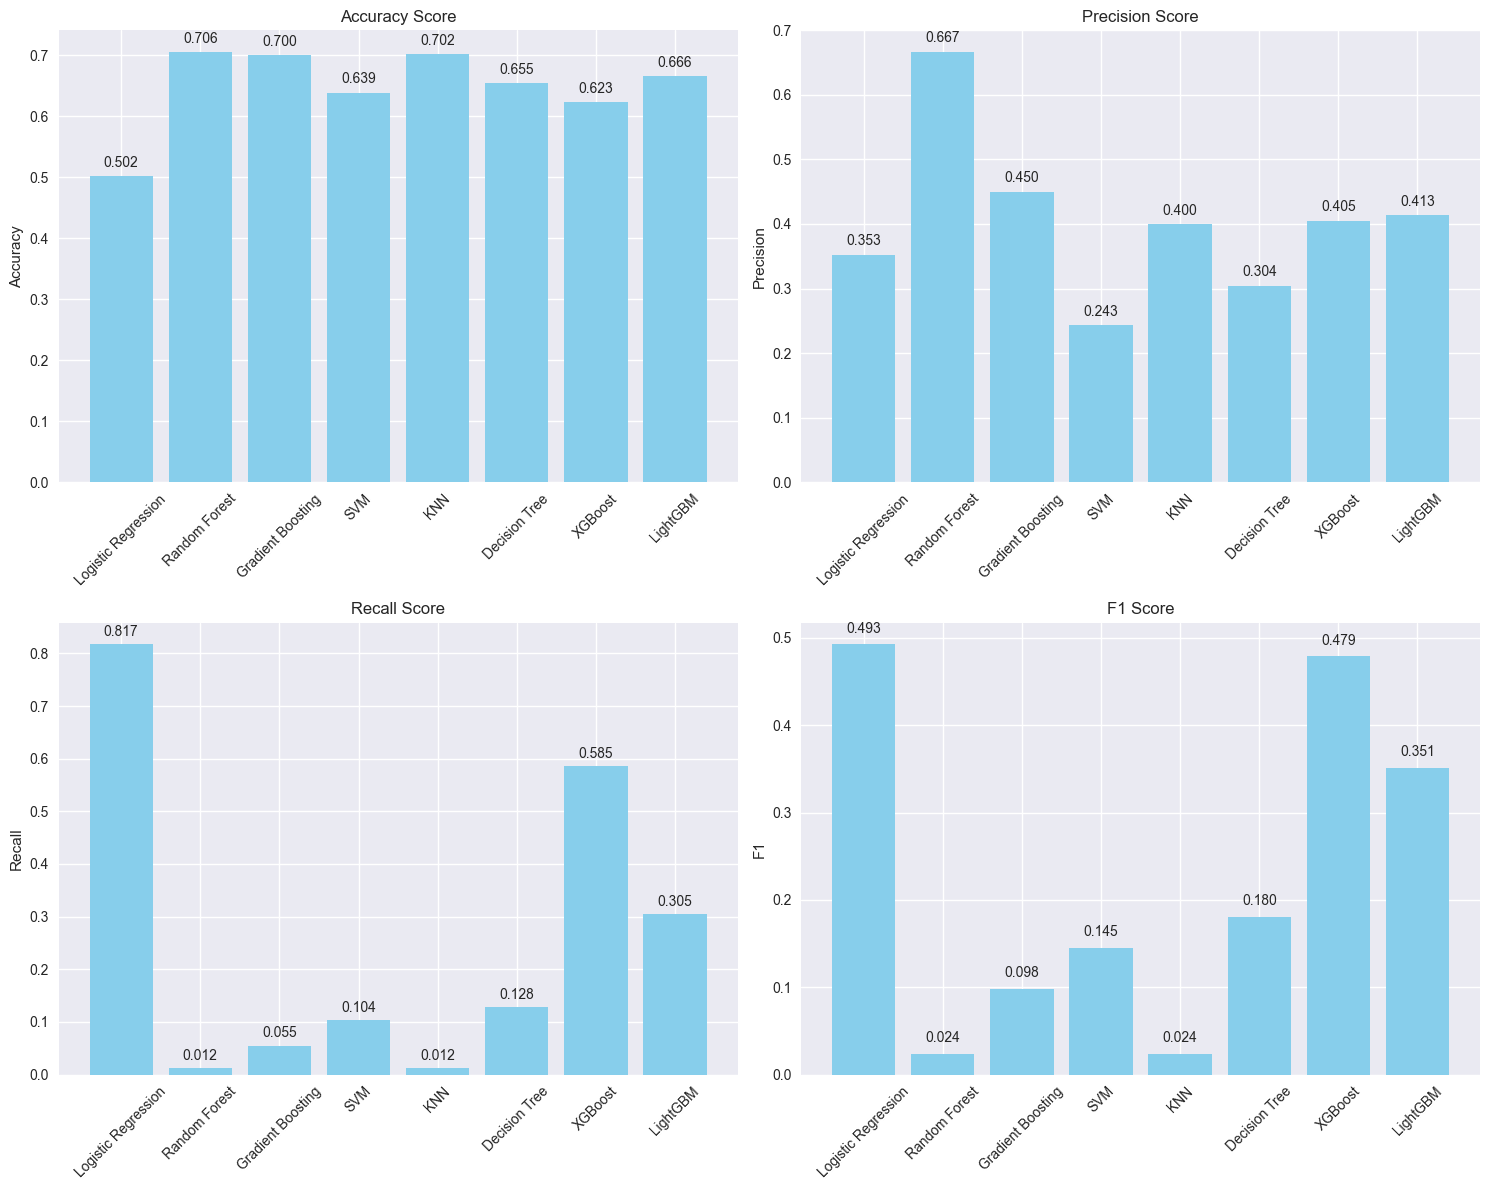

In [11]:
# ============================================================================
# 셀 8: 모델 성능 비교 시각화
# ============================================================================

# 성능 비교 시각화
metrics = ['accuracy', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in models.keys()]
    bars = axes[i].bar(models.keys(), values, color='skyblue')
    axes[i].set_title(f'{metric.title()} Score')
    axes[i].set_ylabel(metric.title())
    axes[i].tick_params(axis='x', rotation=45)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# ============================================================================
# 셀 9: 최고 성능 모델 선택 및 하이퍼파라미터 튜닝
# ============================================================================

# 최고 F1 점수 모델 선택
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"🏆 최고 성능 모델: {best_model_name}")
print(f"   - F1 Score: {results[best_model_name]['f1']:.4f}")

# Random Forest 하이퍼파라미터 튜닝
if best_model_name == 'Random Forest':
    print("\n🔧 Random Forest 하이퍼파라미터 튜닝 중...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_search = GridSearchCV(
        rf, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
    )
    grid_search.fit(X_train_processed, y_train)
    
    print(f"✅ 최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"✅ 최적 F1 Score: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_processed)
    y_pred_proba_rf = best_rf.predict_proba(X_test_processed)[:, 1]
    
    print(f"\n📊 튜닝된 Random Forest 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_rf):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_rf):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
    print(f"- AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

🏆 최고 성능 모델: Logistic Regression
   - F1 Score: 0.4926


In [13]:
# ============================================================================
# 셀 9-1: 최고 성능 모델 선택 및 하이퍼파라미터 튜닝
# ============================================================================
print("🔍 모델 선택 기준 분석:")
print("=" * 60)

# 각 지표별 최고 성능 모델
best_accuracy = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_precision = max(results.keys(), key=lambda x: results[x]['precision'])
best_recall = max(results.keys(), key=lambda x: results[x]['recall'])
best_f1 = max(results.keys(), key=lambda x: results[x]['f1'])
best_auc = max(results.keys(), key=lambda x: results[x]['auc'] if results[x]['auc'] else 0)

print(f"📊 각 지표별 최고 성능 모델:")
print(f"  - Accuracy: {best_accuracy} ({results[best_accuracy]['accuracy']:.4f})")
print(f"  - Precision: {best_precision} ({results[best_precision]['precision']:.4f})")
print(f"  - Recall: {best_recall} ({results[best_recall]['recall']:.4f})")
print(f"  - F1 Score: {best_f1} ({results[best_f1]['f1']:.4f})")
print(f"  - AUC: {best_auc} ({results[best_auc]['auc']:.4f})")

# 비즈니스 관점에서의 모델 선택
print(f"\n🎯 비즈니스 관점에서의 모델 선택:")

# 종합 점수 계산 (가중 평균)
def calculate_composite_score(model_name, results):
    """종합 점수 계산: AUC 40% + F1 30% + Precision 20% + Recall 10%"""
    auc_score = results[model_name]['auc'] if results[model_name]['auc'] else 0
    f1_score = results[model_name]['f1']
    precision_score = results[model_name]['precision']
    recall_score = results[model_name]['recall']
    
    # 정규화 (0-1 범위로)
    composite = (auc_score * 0.4 + f1_score * 0.3 + 
                precision_score * 0.2 + recall_score * 0.1)
    return composite

# 각 모델의 종합 점수 계산
composite_scores = {}
for model_name in results.keys():
    composite_scores[model_name] = calculate_composite_score(model_name, results)

# 종합 점수 기준 최고 모델
best_composite = max(composite_scores.keys(), key=lambda x: composite_scores[x])

print(f"  📊 종합 점수 기준 (AUC 40% + F1 30% + Precision 20% + Recall 10%):")
for model_name in sorted(composite_scores.keys(), key=lambda x: composite_scores[x], reverse=True)[:3]:
    print(f"    - {model_name}: {composite_scores[model_name]:.4f}")

# 최종 모델 선택
if composite_scores[best_composite] > 0.4:  # 임계값 설정
    recommended_model = best_composite
    selection_reason = f"종합 점수 기준 - 균형잡힌 성능 (점수: {composite_scores[best_composite]:.4f})"
else:
    # F1 Score 기준으로 폴백
    recommended_model = best_f1
    selection_reason = "F1 Score 기준 - 종합 점수가 낮아 F1 기준으로 선택"

# 최종 모델 선택
best_model_name = recommended_model
print(f"\n🏆 최종 선택 모델: {best_model_name}")
print(f"   - 선택 이유: {selection_reason}")
print(f"   - F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"   - AUC: {results[best_model_name]['auc']:.4f}" if results[best_model_name]['auc'] else "   - AUC: N/A")

# Random Forest 하이퍼파라미터 튜닝
if best_model_name == 'Random Forest':
    print("\n🔧 Random Forest 하이퍼파라미터 튜닝 중...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_search = GridSearchCV(
        rf, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
    )
    grid_search.fit(X_train_processed, y_train)
    
    print(f"✅ 최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"✅ 최적 F1 Score: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_processed)
    y_pred_proba_rf = best_rf.predict_proba(X_test_processed)[:, 1]
    
    print(f"\n📊 튜닝된 Random Forest 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_rf):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_rf):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
    print(f"- AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")



🔍 모델 선택 기준 분석:
📊 각 지표별 최고 성능 모델:
  - Accuracy: Random Forest (0.7058)
  - Precision: Random Forest (0.6667)
  - Recall: Logistic Regression (0.8171)
  - F1 Score: Logistic Regression (0.4926)
  - AUC: Gradient Boosting (0.6484)

🎯 비즈니스 관점에서의 모델 선택:
  📊 종합 점수 기준 (AUC 40% + F1 30% + Precision 20% + Recall 10%):
    - Logistic Regression: 0.5522
    - XGBoost: 0.5381
    - LightGBM: 0.4712

🏆 최종 선택 모델: Logistic Regression
   - 선택 이유: 종합 점수 기준 - 균형잡힌 성능 (점수: 0.5522)
   - F1 Score: 0.4926
   - AUC: 0.6303


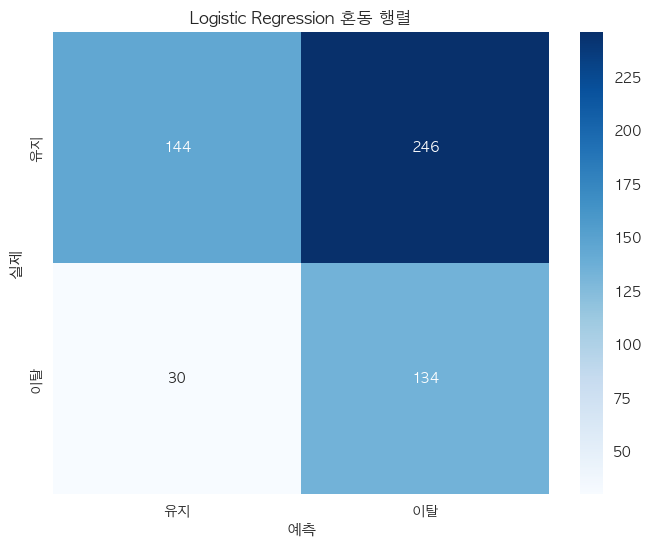


📋 Logistic Regression 분류 리포트:
              precision    recall  f1-score   support

          유지       0.83      0.37      0.51       390
          이탈       0.35      0.82      0.49       164

    accuracy                           0.50       554
   macro avg       0.59      0.59      0.50       554
weighted avg       0.69      0.50      0.51       554



In [14]:
# ============================================================================
# 셀 10: 혼동 행렬 시각화
# ============================================================================
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False 

if best_model_name == 'Random Forest' and 'best_rf' in locals():
    model_for_cm = best_rf
    y_pred_for_cm = y_pred_rf
else:
    model_for_cm = models[best_model_name]
    model_for_cm.fit(X_train_processed, y_train)
    y_pred_for_cm = model_for_cm.predict(X_test_processed)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_for_cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['유지', '이탈'], yticklabels=['유지', '이탈'])
plt.title(f'{best_model_name} 혼동 행렬')
plt.xlabel('예측')
plt.ylabel('실제')
plt.show()

# 분류 리포트
print(f"\n📋 {best_model_name} 분류 리포트:")
print(classification_report(y_test, y_pred_for_cm, target_names=['유지', '이탈']))


[LightGBM] [Info] Number of positive: 673, number of negative: 4600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 5273, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 673, number of negative: 4600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 5273, number of used features: 89
[LightGBM] [Info] [binary:

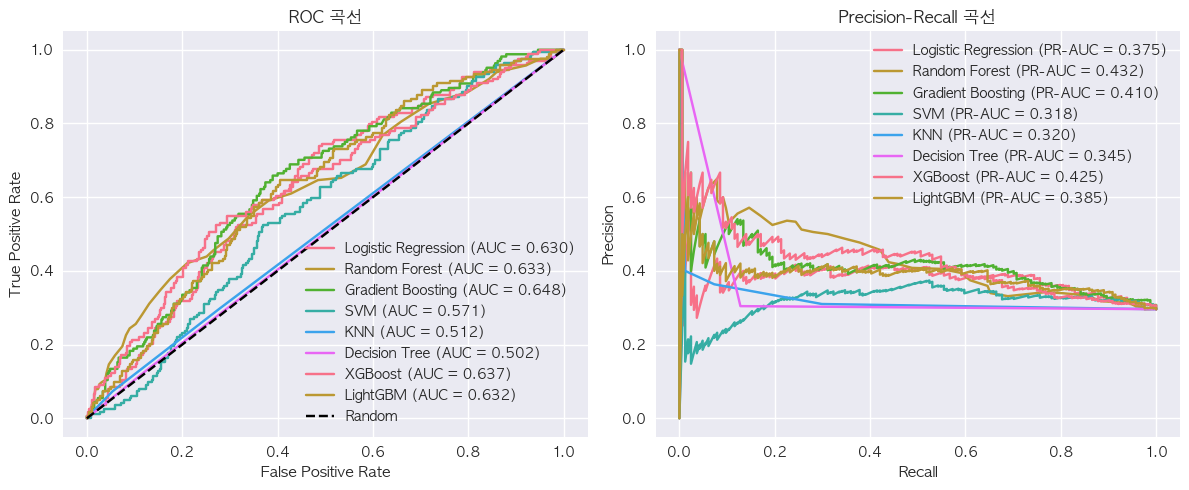

In [15]:
# ============================================================================
# 셀 11: ROC 곡선 및 AUC
# ============================================================================

# ROC 곡선 그리기
plt.figure(figsize=(12, 5))

# 서브플롯 1: ROC 곡선
plt.subplot(1, 2, 1)
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_processed, y_train)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선')
plt.legend()
plt.grid(True)

# 서브플롯 2: Precision-Recall 곡선
plt.subplot(1, 2, 2)
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_processed, y_train)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall 곡선')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# ============================================================================
# 셀 12: 피쳐 중요도 분석 (Random Forest)
# ============================================================================

if best_model_name == 'Random Forest':
    # 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🎯 Random Forest 피쳐 중요도 (상위 10개):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # 피쳐 중요도 시각화
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('피쳐 중요도')
    plt.title('Random Forest 피쳐 중요도 (상위 15개)')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{importance:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

In [17]:
# ============================================================================
# 셀 13: 임계값 조정 및 성능 최적화
# ============================================================================

# 최고 성능 모델의 예측 확률
if hasattr(model_for_cm, 'predict_proba'):
    y_pred_proba = model_for_cm.predict_proba(X_test_processed)[:, 1]
    
    # 다양한 임계값에서 성능 확인
    thresholds = np.arange(0.1, 0.9, 0.05)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        threshold_results.append({
            'threshold': threshold,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    
    # 최적 임계값 찾기
    optimal_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
    print(f"🎯 최적 임계값: {optimal_threshold:.3f}")
    
    # 최적 임계값으로 예측
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    
    print(f"\n📊 최적 임계값 적용 후 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_optimal):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_optimal):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

🎯 최적 임계값: 0.600

📊 최적 임계값 적용 후 성능:
- Accuracy: 0.5758
- Precision: 0.3851
- Recall: 0.7256
- F1-Score: 0.5032


💡 모델 해석 및 비즈니스 인사이트:

📊 모델 성능 요약:
- 최고 성능 모델: Logistic Regression
- F1 Score: 0.4926
- AUC: 0.6303

🎯 모델 해석 (SHAP):
🔍 SHAP 분석 시작...


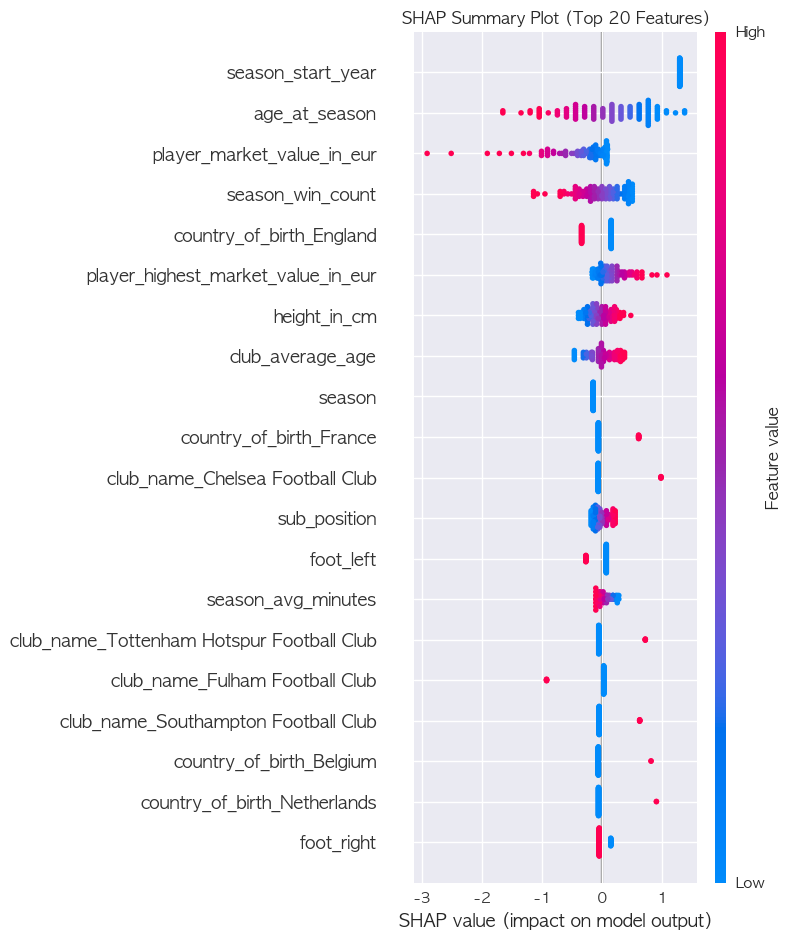

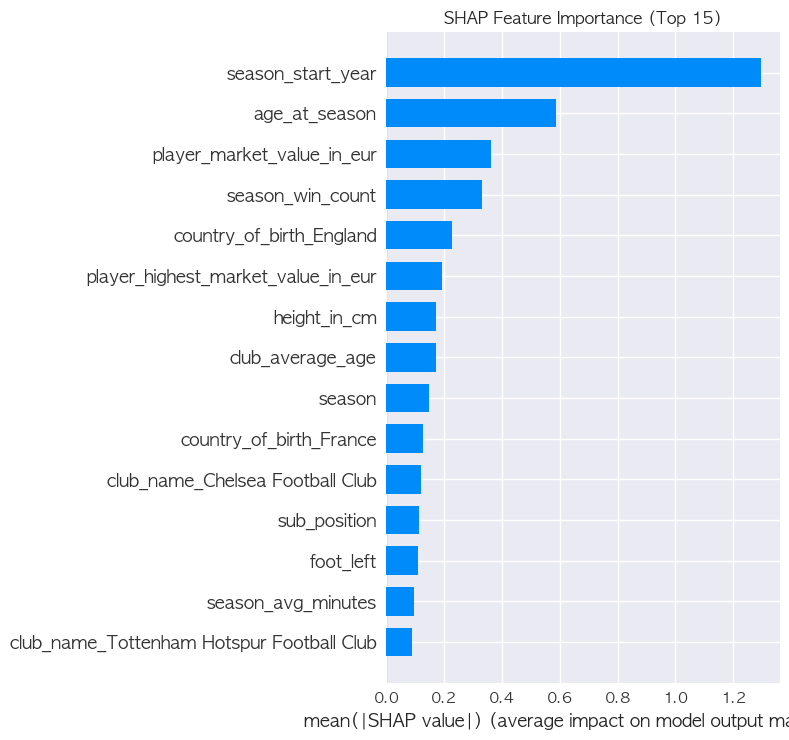

✅ SHAP 분석 완료!

🚀 적용 권장사항 (Football):
1. 잦은 이적(transfer=1) 예측 선수에 대한 재계약/임대 전략 수립
2. 높은 이적확률 포지션/연령대에 대한 스쿼드 리스크 관리
3. 시장가치/출전지표 연계 인센티브 설계로 이탈 리스크 완화


In [18]:
# ============================================================================
# 셀 14: 모델 해석 및 비즈니스 인사이트
# ============================================================================

print("💡 모델 해석 및 비즈니스 인사이트:")
print("=" * 60)

print("\n📊 모델 성능 요약:")
print(f"- 최고 성능 모델: {best_model_name}")
print(f"- F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"- AUC: {results[best_model_name]['auc']:.4f}" if results[best_model_name]['auc'] else "- AUC: N/A")

print("\n🎯 모델 해석 (SHAP):")
if _has_shap:
    
    try:
        # 전처리된 특성 이름 추출
        def get_feature_names_from_ct(column_transformer):
            feature_names = []
            for name, trans, cols in column_transformer.transformers_:
                if name == 'remainder' and trans == 'drop':
                    continue
                elif name == 'num':
                    # 수치형 변수
                    feature_names.extend(cols)
                elif name == 'ord':
                    # 순서형 변수 (라벨 인코딩)
                    feature_names.extend(cols)
                elif name == 'nom':
                    # 명목형 변수 (원핫 인코딩)
                    if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
                        ohe = trans.named_steps['onehot']
                        if hasattr(ohe, 'get_feature_names_out'):
                            names = ohe.get_feature_names_out(cols)
                        else:
                            names = ohe.get_feature_names(cols)
                        feature_names.extend(list(names))
                    else:
                        feature_names.extend(cols)
            return feature_names

        processed_feature_names = get_feature_names_from_ct(preprocessor)
        explainer_model = best_rf if best_model_name == 'Random Forest' and 'best_rf' in locals() else models[best_model_name]
        
        if hasattr(explainer_model, 'predict_proba'):
            print("🔍 SHAP 분석 시작...")
            
            # SHAP Explainer 생성 (TreeExplainer 사용)
            if best_model_name == 'Random Forest' and 'best_rf' in locals():
                explainer = shap.TreeExplainer(best_rf)
            else:
                explainer = shap.Explainer(explainer_model, X_train_processed)
            
            # SHAP 값 계산 (샘플 크기 제한으로 메모리 절약)
            sample_size = min(100, X_test_processed.shape[0])
            X_test_sample = X_test_processed[:sample_size]
            shap_values = explainer(X_test_sample)
            
            # SHAP Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test_sample, 
                            feature_names=processed_feature_names, 
                            max_display=20, show=False)
            plt.title('SHAP Summary Plot (Top 20 Features)')
            plt.tight_layout()
            plt.show()
            
            # SHAP Bar Plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_sample, 
                            feature_names=processed_feature_names, 
                            plot_type="bar", max_display=15, show=False)
            plt.title('SHAP Feature Importance (Top 15)')
            plt.tight_layout()
            plt.show()
            
            print("✅ SHAP 분석 완료!")
            
    except Exception as e:
        print(f"❌ SHAP 해석 오류: {e}")
        print("💡 SHAP 문제 해결 방법:")
        print("  1. 메모리 부족: 샘플 크기 줄이기")
        print("  2. 모델 호환성: TreeExplainer 사용")
        print("  3. 데이터 타입: 전처리된 데이터 확인")
else:
    print("❌ SHAP 미설치/비호환으로 생략됨")

print("\n🚀 적용 권장사항 (Football):")
print("1. 잦은 이적(transfer=1) 예측 선수에 대한 재계약/임대 전략 수립")
print("2. 높은 이적확률 포지션/연령대에 대한 스쿼드 리스크 관리")
print("3. 시장가치/출전지표 연계 인센티브 설계로 이탈 리스크 완화")

In [ ]:
# ============================================================================
# 셀 15: 모델 성능 요약 및 결론
# ============================================================================

print("📋 모델링 프로젝트 요약:")
print("=" * 60)

print("\n📊 데이터 개요:")
print(f"- 총 샘플 수: {len(df_model):,}명")
print(f"- 양성 비율({target_col}): {df_model[target_col].mean()*100:.1f}%")
print(f"- 사용된 피쳐 수: {len(modeling_features)}개")

print("\n🏆 최종 모델 성능:")
print(f"- 모델: {best_model_name}")
print(f"- Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"- Precision: {results[best_model_name]['precision']:.4f}")
print(f"- Recall: {results[best_model_name]['recall']:.4f}")
print(f"- F1-Score: {results[best_model_name]['f1']:.4f}")
if results[best_model_name]['auc']:
    print(f"- AUC: {results[best_model_name]['auc']:.4f}")


📋 모델링 프로젝트 요약:

📊 데이터 개요:
- 총 샘플 수: 5,827명
- 양성 비율(transfer): 14.4%
- 사용된 피쳐 수: 21개

🏆 최종 모델 성능:
- 모델: Logistic Regression
- Accuracy: 0.5018
- Precision: 0.3526
- Recall: 0.8171
- F1-Score: 0.4926
- AUC: 0.6303
